# TP2 RN2

In [2]:
from sklearn.datasets import fetch_20newsgroups
from matplotlib import pyplot as plt
from collections import Counter
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
import gensim
import os, re, csv, math, codecs

In [3]:
TNG_train = fetch_20newsgroups(subset="train")

Tokenizamos el dset

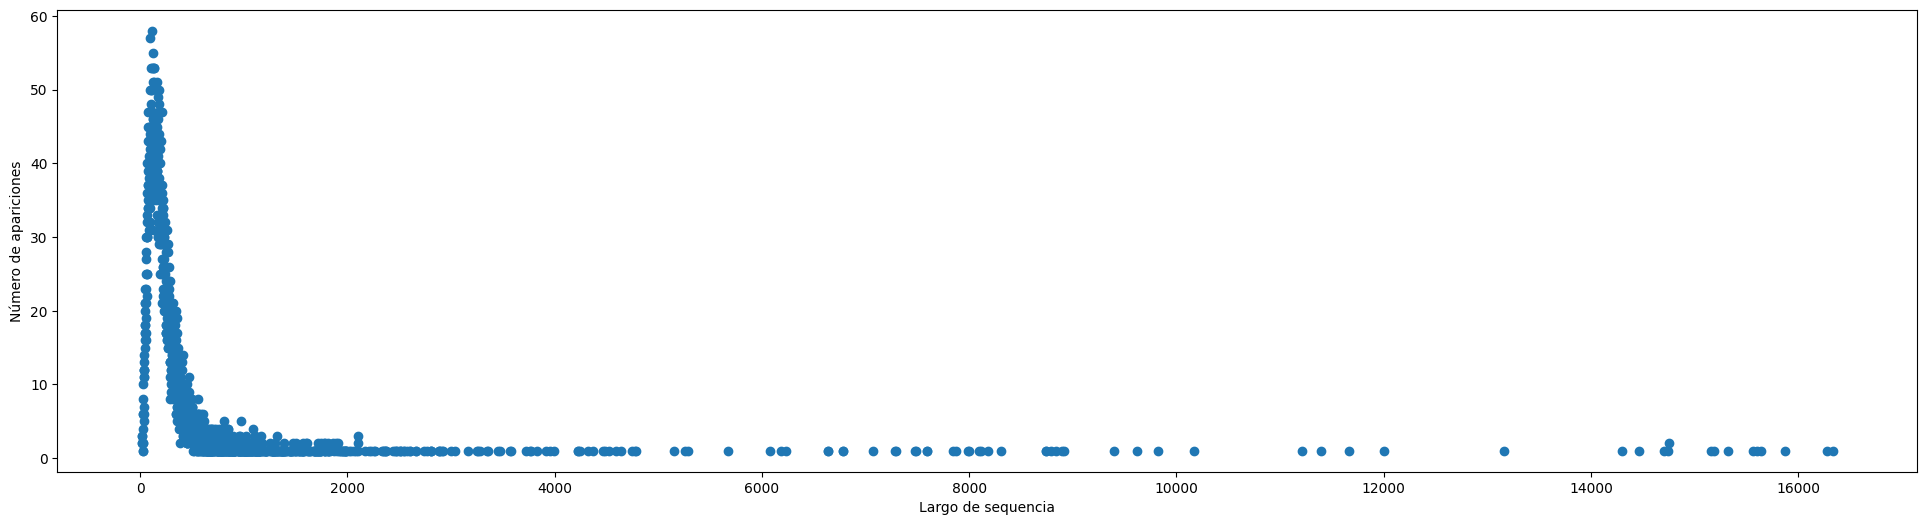

In [4]:
max_words=30000
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token="UNK", document_count=0)
tokenizer.fit_on_texts(TNG_train.data)
seqs=tokenizer.texts_to_sequences(TNG_train.data)

lengths=[len(seq) for seq in seqs]
lengths=dict(Counter(lengths))
plt.figure(figsize=[24,6])
plt.scatter(list(lengths.keys()), list(lengths.values()))
plt.xlabel("Largo de sequencia")
plt.ylabel("Número de apariciones")
#plt.ylim(0,100)
plt.show()

Tomamos como hasta secuencias de largo 400

In [5]:
max_len = 400
pad_seqs = pad_sequences(seqs, maxlen=max_len)

reverse_dictionary = tokenizer.index_word
dictionary = dict([(value, key) for (key, value) in reverse_dictionary.items()])
subset = {key: value for key, value in dictionary.items() if value < 100}

In [6]:
# Downloading fasttext word vectors
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
!unzip wiki-news-300d-1M.vec.zip

--2023-10-03 19:21:13--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.51, 3.162.163.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  41.3MB/s    in 6.2s    

2023-10-03 19:21:19 (106 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [7]:
#load embeddings
EMBEDDING_DIR = "/content/"
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open(EMBEDDING_DIR+'wiki-news-300d-1M.vec', encoding='utf-8')
for line in f:
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))


loading word embeddings...
found 999995 word vectors


In [8]:
embed_dim=300
num_words=len(dictionary)+1
embedding_matrix=np.zeros([num_words,embed_dim])
for word, idx in dictionary.items():
  if idx <= num_words and word in embeddings_index:
    embedding_matrix[idx,:]=embeddings_index[word]

# Attention (Embedding -> CNN -> Softmax) + MLP

In [10]:
from tensorflow.keras.layers import Embedding, Reshape, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, Dense, Input, Concatenate,Dot,RepeatVector,TimeDistributed,Multiply,Lambda,Flatten, Activation, BatchNormalization
import tensorflow.keras.backend as K
from tensorflow.keras.activations import softmax
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

from tensorflow.keras.callbacks import ReduceLROnPlateau

In [12]:
def softMaxOverTime(x):
    return softmax(x,axis=1)

nb_words=num_words

value_dim=64
input_layer = Input(shape=(max_len,))
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=True)(input_layer)

conv_out=Conv1D(value_dim,2,padding="same", activation='tanh')(embedding_layer)
conv_out = Dropout(0.5)(conv_out)
conv_out=Conv1D(value_dim,4,padding="same", activation='tanh')(embedding_layer)
conv_out = Dropout(0.5)(conv_out)
conv_out=Conv1D(value_dim,8, padding="same", activation='tanh')(conv_out)
conv_out = Dropout(0.5)(conv_out)

ulog_attention=Dense(1,activation="linear")(conv_out)

attention=Activation(softMaxOverTime)(ulog_attention)

repeated_attention=TimeDistributed(RepeatVector(value_dim))(attention)
repeated_attention=Reshape([max_len,value_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,conv_out])

embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

dense1=Dense(100, activation='relu')(embedding_sum)
dense1 = Dropout(0.5)(dense1)
dense1=Dense(50, activation='relu')(dense1)
dense1 = Dropout(0.5)(dense1)
dense2=Dense(20, activation='softmax')(dense1)
model=Model(input_layer , dense2)
adam = optimizers.Nadam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 400, 300)             4024320   ['input_2[0][0]']             
                                                          0                                       
                                                                                                  
 conv1d_1 (Conv1D)           (None, 400, 64)              76864     ['embedding[0][0]']           
                                                                                                  
 dropout_1 (Dropout)         (None, 400, 64)              0         ['conv1d_1[0][0]']        

In [32]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

model.fit(pad_seqs, TNG_train.target, batch_size=128, epochs=50, validation_split=0.2, callbacks=[reduce_lr])


Epoch 1/50
71/71 [==============================] - 23s 243ms/step - loss: 2.8717 - accuracy: 0.0923 - val_loss: 2.4631 - val_accuracy: 0.2532 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 15s 218ms/step - loss: 2.1938 - accuracy: 0.2785 - val_loss: 1.5253 - val_accuracy: 0.5409 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 14s 191ms/step - loss: 1.5386 - accuracy: 0.4626 - val_loss: 0.9686 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 13s 183ms/step - loss: 1.0863 - accuracy: 0.6232 - val_loss: 0.7270 - val_accuracy: 0.8029 - lr: 0.0010
Epoch 5/50
71/71 [==============================] - 13s 179ms/step - loss: 0.7893 - accuracy: 0.7322 - val_loss: 0.6098 - val_accuracy: 0.8184 - lr: 0.0010
Epoch 6/50
71/71 [==============================] - 11s 150ms/step - loss: 0.6069 - accuracy: 0.7914 - val_loss: 0.5536 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 7/50
71/71 [==============================] - 12s 178ms/st

El uso de dropout y ReduceLROnPlateau logró aumentar el accuracy luego de varias pruebas de hiperparámetros y número de capas.

# TextCNN

In [15]:
input_layer = Input(shape=(max_len,))
embedding_layer=Embedding(nb_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)

dense_input=Dense(50,activation="tanh")(embedding_layer)
ulog_attention=Dense(1,activation="linear")(dense_input)

attention=Activation(softMaxOverTime)(ulog_attention)
repeated_attention=TimeDistributed(RepeatVector(embed_dim))(attention)
repeated_attention=Reshape([max_len,embed_dim])(repeated_attention)

weighted_embeddings=Multiply()([repeated_attention,embedding_layer])


embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)

conv4 = Conv1D(32, 4, activation='relu', padding='same')(embedding_layer)
conv3 = Conv1D(32, 3, activation='relu', padding='same')(embedding_layer)
conv2 = Conv1D(32, 2, activation='relu', padding='same')(embedding_layer)
pool4 = GlobalMaxPooling1D()(conv4)
pool3 = GlobalMaxPooling1D()(conv3)
pool2 = GlobalMaxPooling1D()(conv2)
cnn_output = Concatenate()([pool4, pool3, pool2])

combined = Concatenate()([embedding_sum, cnn_output])

dense1 = Dense(80, activation='relu')(combined)
dense2 = Dense(40, activation='relu')(combined)
output_layer = Dense(20, activation='softmax')(dense2)

model = Model(input_layer, output_layer)
adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 400)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 400, 300)             4024320   ['input_4[0][0]']             
                                                          0                                       
                                                                                                  
 dense_8 (Dense)             (None, 400, 50)              15050     ['embedding_2[0][0]']         
                                                                                                  
 dense_9 (Dense)             (None, 400, 1)               51        ['dense_8[0][0]']       

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

model.fit(pad_seqs, TNG_train.target, batch_size=128, epochs=50, validation_split=0.2, callbacks=[reduce_lr])


Epoch 1/50
71/71 [==============================] - 8s 38ms/step - loss: 2.8451 - accuracy: 0.1657 - val_loss: 2.4769 - val_accuracy: 0.4105 - lr: 0.0010
Epoch 2/50
71/71 [==============================] - 2s 27ms/step - loss: 1.7550 - accuracy: 0.5979 - val_loss: 1.2374 - val_accuracy: 0.6792 - lr: 0.0010
Epoch 3/50
71/71 [==============================] - 2s 24ms/step - loss: 0.9992 - accuracy: 0.7322 - val_loss: 0.9034 - val_accuracy: 0.7521 - lr: 0.0010
Epoch 4/50
71/71 [==============================] - 2s 25ms/step - loss: 0.7544 - accuracy: 0.7915 - val_loss: 0.7876 - val_accuracy: 0.7658 - lr: 0.0010
Epoch 5/50
71/71 [==============================] - 2s 24ms/step - loss: 0.6158 - accuracy: 0.8272 - val_loss: 0.7009 - val_accuracy: 0.7905 - lr: 0.0010
Epoch 6/50
71/71 [==============================] - 2s 24ms/step - loss: 0.5140 - accuracy: 0.8561 - val_loss: 0.6406 - val_accuracy: 0.8056 - lr: 0.0010
Epoch 7/50
71/71 [==============================] - 2s 27ms/step - loss: 0.4

Increiblemente performó pero que para el caso anterior. El overfitting observado en ambos casos fue grande...